In [2]:
from utils import *
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from collections import deque
import random

# Configure Modeling Parameters and Fetch Data

Enter a ticker and date range you would like to build the model on.  This model takes a a single ticker's data.  Also enter a training size for the proportion of the data you want to include in your training set vs. your test set.

In [3]:
# stock configs
ticker = ['GOOG']
start_date = '2015-04-01'
end_date = '2024-04-05'

# model configs
train_size = 0.8

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 30  # Number of past days we want to use to predict the future.

In [4]:
# Data Fetching
data = fetch_stock_data(ticker, start_date, end_date)[ticker[0]]
data.reset_index(drop=False, inplace=True)
data['Date'] = pd.to_datetime(data['Date']).dt.tz_localize(None)

print(data.shape)
included_days = len(data)
data.head()

(2268, 8)


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2015-04-01,27.354897,27.481548,26.901142,27.053724,39261497,0.0,0.0
1,2015-04-02,26.968458,26.968458,26.619267,26.703186,34327989,0.0,0.0
2,2015-04-06,26.538139,26.846792,26.406002,26.764767,26488525,0.0,0.0
3,2015-04-07,26.830338,27.060205,26.726622,26.777481,26057345,0.0,0.0
4,2015-04-08,26.845297,27.118048,26.845297,27.006353,23570536,0.0,0.0


# Stock Trading Signal Agent

This code implements a simple stock trading signal agent that makes buy and sell decisions based on the price movement of a stock. The agent follows a basic strategy of buying when the price is falling and selling when the price is rising, with a delay to change the decision.

## Function Parameters

- `real_movement`: A list or array representing the actual price movement of the stock.
- `delay`: The number of intervals to delay before changing the decision from buy to sell or vice versa (default is 5).
- `initial_state`: The initial state of the agent, where 1 represents a buy state and 0 represents a sell state (default is 1).
- `initial_money`: The initial amount of money available to the agent (default is 10000).
- `max_buy`: The maximum quantity of shares to buy in a single transaction (default is 1).
- `max_sell`: The maximum quantity of shares to sell in a single transaction (default is 1).

## Agent's Decision Making Process

1. The agent starts with an initial state (buy or sell) and an initial amount of money.
2. It iterates through the price movement data point by point.
3. If the current price is lower than the previous price and the agent is in a sell state, it waits for a specified number of intervals (delay) before changing its decision to a buy state.
4. If the current price is higher than the previous price and the agent is in a buy state, it waits for a specified number of intervals (delay) before changing its decision to a sell state.
5. When the agent decides to buy, it calculates the number of shares it can purchase based on the current price and the available money. It buys the shares and updates the inventory and remaining money.
6. When the agent decides to sell, it checks if there are any shares in the inventory. If there are shares, it sells them at the current price and updates the inventory and money.
7. The agent keeps track of the buy and sell transactions, including the day, price, quantity, and investment performance.

## Output

The function returns the following:
- `states_buy`: A list of days when the agent made buy decisions.
- `states_sell`: A list of days when the agent made sell decisions.
- `total_gains`: The total profit or loss made by the agent.
- `invest`: The percentage return on investment.

Note: This is a simplified stock trading agent and does not take into account various factors and risks involved in real-world trading. It is for educational purposes only.

In [13]:
def buy_stock(
    real_movement,
    delay=5,
    initial_state=1,
    initial_money=10000,
    max_buy=1,
    max_sell=1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    delay_change_decision = delay
    current_decision = 0
    state = initial_state
    current_val = real_movement[0]
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            buy_units = min(shares, max_buy)
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    def sell(i, initial_money, current_inventory):
        if current_inventory == 0:
            print('day %d: cannot sell anything, inventory 0' % (i))
        else:
            sell_units = min(current_inventory, max_sell)
            current_inventory -= sell_units
            total_sell = sell_units * real_movement[i]
            initial_money += total_sell
            invest = (
                (real_movement[i] - real_movement[states_buy[-1]])
                / real_movement[states_buy[-1]]
            ) * 100 if states_buy else 0
            print(
                'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                % (i, sell_units, total_sell, invest, initial_money)
            )
            states_sell.append(i)
        return initial_money, current_inventory

    if state == 1:
        initial_money, current_inventory = buy(0, initial_money, current_inventory)

    for i in range(1, len(real_movement)):
        if real_movement[i] < current_val and state == 0:
            current_decision = current_decision + 1 if current_decision < delay_change_decision else 0
            if current_decision == 0:
                state = 1
                initial_money, current_inventory = buy(i, initial_money, current_inventory)
                states_buy.append(i)
        elif real_movement[i] > current_val and state == 1:
            current_decision = current_decision + 1 if current_decision < delay_change_decision else 0
            if current_decision == 0:
                state = 0
                initial_money, current_inventory = sell(i, initial_money, current_inventory)
        current_val = real_movement[i]

    # Sell remaining shares at the last price point
    if current_inventory > 0:
        last_price = real_movement[len(real_movement) - 1]
        total_sell = current_inventory * last_price
        initial_money += total_sell
        invest = (
            (last_price - real_movement[states_buy[-1]])
            / real_movement[states_buy[-1]]
        ) * 100 if states_buy else 0
        print(
            'day %d, sell remaining %d units at price %f, investment %f %%, total balance %f,'
            % (len(real_movement) - 1, current_inventory, total_sell, invest, initial_money)
        )
        states_sell.append(len(real_movement) - 1)
        current_inventory = 0

    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [14]:
states_buy, states_sell, total_gains, invest = buy_stock(data.Close, initial_state = 1, 
                                                         delay = 4, initial_money = 10000)

day 0: buy 1 units at price 27.053724, total balance 9972.946276
day 10, sell 1 units at price 26.616922, investment -1.614572 %, total balance 9999.563198,
day 19: buy 1 units at price 27.454000, total balance 9972.109198
day 29, sell 1 units at price 26.481001, investment -3.544109 %, total balance 9998.590199,
day 39: buy 1 units at price 26.989000, total balance 9971.601198
day 52, sell 1 units at price 26.407499, investment -2.154585 %, total balance 9998.008698,
day 61: buy 1 units at price 26.076000, total balance 9971.932697
day 69, sell 1 units at price 26.506500, investment 1.650943 %, total balance 9998.439198,
day 78: buy 1 units at price 32.214001, total balance 9966.225197
day 85, sell 1 units at price 31.560499, investment -2.028626 %, total balance 9997.785696,
day 92: buy 1 units at price 32.978001, total balance 9964.807695
day 103, sell 1 units at price 31.880501, investment -3.327976 %, total balance 9996.688196,
day 109: buy 1 units at price 30.035000, total balanc

In [15]:
import plotly.graph_objects as go

def visualize_stock_trading(close, states_buy, states_sell, total_gains, invest):
    fig = go.Figure()

    # Plot the closing price
    fig.add_trace(go.Scatter(x=list(range(len(close))), y=close, mode='lines', name='Closing Price', line=dict(color='blue', width=2)))

    # Plot the buying signals
    buy_indices = [i for i in range(len(close)) if i in states_buy]
    buy_prices = [close[i] for i in buy_indices]
    fig.add_trace(go.Scatter(x=buy_indices, y=buy_prices, mode='markers', name='Buying Signal', marker=dict(symbol='triangle-up', size=10, color='green')))

    # Plot the selling signals
    sell_indices = [i for i in range(len(close)) if i in states_sell]
    sell_prices = [close[i] for i in sell_indices]
    fig.add_trace(go.Scatter(x=sell_indices, y=sell_prices, mode='markers', name='Selling Signal', marker=dict(symbol='triangle-down', size=10, color='red')))

    # Customize the layout
    fig.update_layout(
        title=f'Total Gains: {total_gains:.2f}, Total Investment: {invest:.2f}%',
        xaxis_title='Day',
        yaxis_title='Price',
        template='plotly_dark',
        hovermode='x',
        legend=dict(x=0, y=1, orientation='h')
    )

    fig.show()

In [16]:
visualize_stock_trading(data.Close, states_buy, states_sell, total_gains, invest)

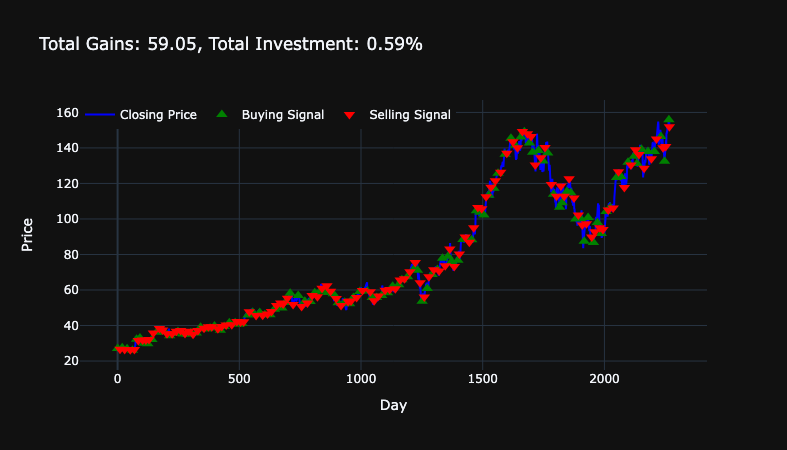